# Modelo de regresión simple

Se aplicará un modelo de regresión lineal a un conjunto de datos que provienen de un experimento del área de física moderna. Este experimento se realizó para verificar la veracidad de la ley de *Steffan-Boltzman*, cuya ecuación está basada en que todo cupero emite radiación en forma de energía electromagnética; la potencia total radiada por un cuerpo es proporcional a su área $A$, también depende de la naturaleza de la superficie que irradia y de su temperatura absoluta $T$ (en kelvin). La ecuación dada por la ley de Stefan – Boltzmann está dada por:

$$
P(T)=Ae\sigma T^{4},
$$

donde $\sigma \approx 5.670373\times 10^{-8}\frac{W}{m^{2}K^{4}}$ es la constante de Stefan-Boltzmann y $e$, un número adimensional que puede variar entre 0 y 1, es la emisividad la cual caracteriza las propiedades de emisión de una superficie y depende del material. 

Sin embargo, para nuestros propósitos no nos interesa adentrarnos a la parte física del experimento, sino a la parte estadística. Se empleará un modelo de regresión lineal simple empleando el escalamiento logarítmico para describir el comportamiento de esta muestra experimental. Por otro lado, cabe mencionar ciertas características del equipo experimental, el área $A$ usada en este caso es un poco mayor al área unitaria de tal forma que el producto $Ae$ se espera mayor a $1$; por otro lado, la prescisión del voltímetro usado es del orden de $[mW]$, implicando que el coeficiente $Ae\sigma$ sea del orden de $10^{-11}$.

Para entender mejor la metodología empleada, se describirá teóricamente la regresión lineal simple, así como otras herramientas para verificar la exactitud de nuestro modelo a través de las simulaciones, además de las estadísitcas descriptivas.

A lo largo de este notebook se mostrará el código y metodología usada para la exploración, análisis y transformación del dataset, así como la construcción del modelo.


### Instalación de modulos

Se instalrán los modulos que no tenga por defecto el ambiente donde se ejecute el código puesto que este código se podrá ejecutar en distintos ambientes virtuales.

In [25]:
!pip install plotly

In [26]:
!pip install pandas

In [27]:
!pip install matplotlib

In [28]:
!pip install sklearn

### Importando módulos

Para empezar la exploración del dataset se importarán solo los módulos necesarios para el proyecto.

In [71]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly
import re
print('Modulos importados')

Modulos importados


### Dataset loading
Carguemos el dataset:

In [72]:
dataset_url = 'datos_esta.csv'
df = pd.read_csv(dataset_url)

### Exploración del dataset

Veamos los datos que contiene el dataset:

In [73]:
df.head()

,Temperatura_C,Temperatura_K,Fem_mV
0,169,442,2.149
1,170,443,2.170
2,171,444,2.193
3,172,445,2.214
4,173,446,2.238


In [74]:
df.tail()

,Temperatura_C,Temperatura_K,Fem_mV
204,391,664,11.135
205,392,665,11.206
206,393,666,11.257
207,394,667,11.321
208,395,668,11.383


In [75]:
df.shape

(209, 3)

In [76]:
df.describe()

,Temperatura_C,Temperatura_K,Fem_mV
count,209.000000,209.000000,209.000000
mean,279.846890,552.846890,5.960096
std,65.555434,65.555434,2.679898
min,169.000000,442.000000,2.149000
25%,224.000000,497.000000,3.607000
50%,279.000000,552.000000,5.573000
75%,336.000000,609.000000,8.119000
max,395.000000,668.000000,11.383000


### Visualizaciones
Con el propósito de entender mejor el comportamiento de los datos, grafiquemos las relaciones de nuestro interés.

In [35]:
column_names = list(df.columns)
print(column_names)

['Temperatura_C', 'Temperatura_K', 'Fem_mV']


In [36]:
fig = go.Figure(
data = go.Scatter(
    x= df['Temperatura_C'],
    y = df['Fem_mV'],
    mode = 'markers',
    marker = dict(
    size = 10,
    color = df['Temperatura_C'],
    showscale = True,
    ),
    text = df['Temperatura_C']
)
)

fig.update_layout(title = r'$Fem \,\, vs \,\, Temperatura$'
                 , xaxis_title = r'$Temperatura[C]$'
                 , yaxis_title = r'$Fem[mV]$'
                 , autosize=False
                 , width=1150
                 , height=800)
fig.show()

Debido a que nos interesa modelarlo a traveés de una regresión lineal, transformemos lsod atos de manera logarítmica, base 10, para determinar si se puede modelar linealmente.

In [37]:
df['ln_Temperatura_C'] = np.log10(df['Temperatura_C'])
df['ln_Temperatura_K'] = np.log10(df['Temperatura_K'])
df['ln_Fem'] = np.log10(df['Fem_mV'])
df.head()

,Temperatura_C,Temperatura_K,Fem_mV,ln_Temperatura_C,ln_Temperatura_K,ln_Fem
0,169,442,2.149,2.227887,2.645422,0.332236
1,170,443,2.170,2.230449,2.646404,0.336460
2,171,444,2.193,2.232996,2.647383,0.341039
3,172,445,2.214,2.235528,2.648360,0.345178
4,173,446,2.238,2.238046,2.649335,0.349860


Como nos sirven las columnas asosciadas a la escala de centigrados, eliminémoslas:

In [38]:
df.drop('Temperatura_C', axis=1)
df.drop('ln_Temperatura_C', axis=1)
df.head()

,Temperatura_C,Temperatura_K,Fem_mV,ln_Temperatura_C,ln_Temperatura_K,ln_Fem
0,169,442,2.149,2.227887,2.645422,0.332236
1,170,443,2.170,2.230449,2.646404,0.336460
2,171,444,2.193,2.232996,2.647383,0.341039
3,172,445,2.214,2.235528,2.648360,0.345178
4,173,446,2.238,2.238046,2.649335,0.349860


In [39]:
fig = go.Figure(
data = go.Scatter(
    x= df['ln_Temperatura_K'],
    y = df['ln_Fem'],
    mode = 'markers',
    marker = dict(
    size = 10,
    color = df['Temperatura_K'],
    showscale = True,
    ),
    text = df['Temperatura_K']
)
)

fig.update_layout(title = r'$\log_{10}(Fem) \,\, vs \,\, \log_{10}(Temperatura)$'
                 , xaxis_title = r'$\log_{10}(Temperatura)$'
                 , yaxis_title = r'$\log_{10}(Fem)$'
                 , autosize=False
                 , width=1150
                 , height=600)
fig.show()

### Creación del modelo

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
from sklearn.linear_model import LinearRegression

Indiquemos las imágenes del dataframe con la que se contruirán el modleo: X variable independiente, y variable dependiente.

In [42]:
X = df.iloc[:, -2:-1].values
y = df.iloc[:, -1].values

Verifiquemos que los conjuntos sean los deseados:

In [43]:
print(X[0:5])
print(y[0:5])

[[2.64542227]
 [2.64640373]
 [2.64738297]
 [2.64836001]
 [2.64933486]]
[0.33223642 0.33645973 0.34103863 0.34517762 0.34986008]


Contruyamos el conjunto de entrenamiento y de testeo con la partición usual de 80-20:

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

In [45]:
X_train.shape

(167, 1)

In [46]:
X_train.flatten()

array([2.74193908, 2.77158748, 2.64933486, 2.71516736, 2.76789762,
       2.68930886, 2.70586371, 2.74507479, 2.67209786, 2.73957234,
       2.7930916 , 2.81756537, 2.65321251, 2.68574174, 2.7458552 ,
       2.75966784, 2.76192784, 2.7466342 , 2.8122447 , 2.74429298,
       2.71683772, 2.70415052, 2.67024585, 2.67577834, 2.70329138,
       2.69983773, 2.78103694, 2.72835378, 2.66464198, 2.78532984,
       2.76342799, 2.69810055, 2.79448805, 2.69548168, 2.80413943,
       2.77305469, 2.74350976, 2.77011529, 2.74741181, 2.80550086,
       2.7355989 , 2.77887447, 2.65896484, 2.67302091, 2.74818803,
       2.80955971, 2.66558099, 2.69108149, 2.79795964, 2.82216808,
       2.77378644, 2.70500796, 2.64738297, 2.70243054, 2.82151353,
       2.81491318, 2.68841982, 2.65513843, 2.79098848, 2.71432976,
       2.81954394, 2.82085799, 2.80753503, 2.78031731, 2.7363965 ,
       2.64836001, 2.73239376, 2.75739603, 2.78958071, 2.81888541,
       2.6946052 , 2.74896286, 2.64542227, 2.73319727, 2.76863

Contruyamos el modelo

In [47]:
regression = LinearRegression()

In [48]:
regression.fit(X_train, y_train)
reg = regression.fit(X_train, y_train)

In [49]:
y_pred = regression.predict(X_test)

Por último, veamos el comportamiento gráfico de la regresión tanto con el conjunto de entrenamiento como con el de prueba o testeo.

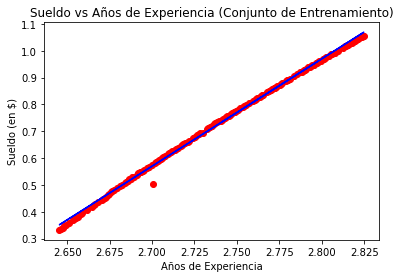

In [50]:
plt.scatter(X_train, y_train, color = "red")
plt.plot(X_train, regression.predict(X_train), color = "blue")
plt.title("Sueldo vs Años de Experiencia (Conjunto de Entrenamiento)")
plt.xlabel("Años de Experiencia")
plt.ylabel("Sueldo (en $)")
plt.show()

In [51]:
fig = go.Figure(
data = go.Scatter(
    x = X_train.flatten(),
    y = y_train.flatten(),
    mode = 'markers',
    marker = dict(
    size = 10,
    color = X_train.flatten(),
    showscale = True,
    ),
    text = X_train
)
)

fig.add_trace(go.Scatter(x=X_train.flatten(), y=regression.predict(X_train).flatten(),
                    mode='lines',
                    #line=go.scatter.Line(color="Black"),
                    line=dict(color="black",
                              width=4),
                    showlegend=False))

fig.update_layout(title = r'$\log_{10}(Fem) \,\, vs \,\, \log_{10}(Temperatura) \,\, - \,\, Conjunto \, de \, entrenamiento$'
                 , xaxis_title = r'$\log_{10}(Temperatura)$'
                 , yaxis_title = r'$\log_{10}(Fem)$'
                 , autosize=False
                 , width=1150
                 , height=800)
fig.show()

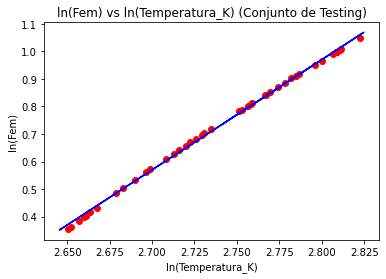

In [52]:
plt.scatter(X_test, y_test, color = "red")
plt.plot(X_train, regression.predict(X_train), color = "blue")
plt.title("ln(Fem) vs ln(Temperatura_K) (Conjunto de Testing)")
plt.xlabel("ln(Temperatura_K)")
plt.ylabel("ln(Fem)")
plt.show()

In [53]:
fig = go.Figure(
data = go.Scatter(
    x = X_test.flatten(),
    y = y_test.flatten(),
    mode = 'markers',
    marker = dict(
    size = 10,
    color = X_test.flatten(),
    showscale = True,
    ),
    text = X_test
)
)

fig.add_trace(go.Scatter(x=X_test.flatten(), y=regression.predict(X_test).flatten(),
                    mode='lines',
                    #line=go.scatter.Line(color="Black"),
                    line=dict(color="black",
                              width=4),
                    showlegend=False))

fig.update_layout(title = r'$\log_{10}(Fem) \,\, vs \,\, \log_{10}(Temperatura) \,\, - \,\, Conjunto \, de \, prueba$'
                 , xaxis_title = r'$\log_{10}(Temperatura)$'
                 , yaxis_title = r'$\log_{10}(Fem)$'
                 , autosize=False
                 , width=1150
                 , height=800)
fig.show()

In [54]:
print(reg.coef_)
print(reg.intercept_)

[4.00246208]
-10.236829393605644


In [55]:
reg.score(X, y)

0.9980572767097294

Debido a que existe la posibilidad de que el conjunto de entrenamiento haya tan particual que la regresión es buena, apliquemos validación curzada para reducir dicha posibilidad y mostrar que para distintos conjuntos de entrenamiento se obtendrán resultados similares:

In [56]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = reg, X = X_train, y = y_train, cv = 10)
print("La media es: " + str(accuracies.mean()))
print("La desviación estandar es: " + str(accuracies.std()))

La media es: 0.997831196799917
La desviación estandar es: 0.002071969923855281


Si deseamos ver el array de los coeficientes de determinación:

In [57]:
accuracies

array([0.99808313, 0.9986294 , 0.99883242, 0.99822115, 0.99811459,
       0.99851464, 0.99174797, 0.99958194, 0.99817059, 0.99841614])

Vemos que la media de los coeficientes de determinación es muy cercana a uno y la desviación estándar, a cero; por lo que podemos concluir que para cualquier conjunto de entrenamiento se obtendrán resultados similares.

Recordemos que se aplico un escalamiento logarítmico base 10, por lo que el modelo final es de la forma:
$$
P(T) = BT^c
$$

con $\alpha$ la constante de Boltzmann. Ahora obtengamos las constantes necesarias para definir nuestro modelo:

In [59]:
B = 10**reg.intercept_
print(B)
c = reg.coef_
print(c)

5.796563614424081e-11
[4.00246208]


### Conclusiones

Por lo tanto, considerando que las cifras siginificativas dadas por la precisión de los intrumentos de medición es del orden $10^{-3}mV$, entonces  la función analítica es:

$$
P(T) = 5.796 \times 10^{-11} T ^{4.002} mW
$$

Notemos que la cosntante $B$ es del orden de $10^{-11}$ porque la $Fem$ está medida en $[mV]$ y no en $[V]$, como se mencionó anteriormente; también se aprecia que la constante $B$ es mayor que la constante de Boltzmann, $\sigma$, como se predijo dadas las características del equipo utilizado.

Si desamos obtener el producto de las constantes $Ae$, dividamos a $B$ entre el valor teórico de la constante $\sigma$ en milésimas:

In [60]:
CB = 5.670373e-11
print("Ae = " + str(B/CB))

Ae = 1.0222543762860188


In [67]:
train = pd.DataFrame({'log_Temperatura': X_train.flatten(), 
              'log_Fem': y_train.flatten()})
train.head()

,log_Temperatura,log_Fem
0,2.741939,0.746089
1,2.771587,0.860038
2,2.649335,0.349860
3,2.715167,0.638589
4,2.767898,0.845904


In [68]:
train.to_csv("train.csv")

In [69]:
test = pd.DataFrame({'log_Temperatura': y_test.flatten(), 
              'log_Fem': y_test.flatten()})
test.head()

,log_Temperatura,log_Fem
0,0.385785,0.385785
1,0.658107,0.658107
2,0.484442,0.484442
3,0.354108,0.354108
4,0.998869,0.998869


In [70]:
test.to_csv("test.csv")